# Load and process data

In [9]:
import pandas as pd

# Load JSONL file (pairwise format with _left/_right suffixes)
gs_path = "data/raw/wdcproducts50cc50rnd000un_gs.json.gz"

df_pairs = pd.read_json(gs_path, compression="gzip", lines=True)

# Inspect available columns
print("Columns:", df_pairs.columns.tolist())
df_pairs[["id_left", "id_right", "label", "pair_id"]].head()


Columns: ['id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'priceCurrency_left', 'cluster_id_left', 'id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'priceCurrency_right', 'cluster_id_right', 'pair_id', 'label', 'is_hard_negative']


,id_left,id_right,label,pair_id
0,40764402,75198999,0,40764402#75198999
1,20397693,63496012,0,20397693#63496012
2,21587796,62282105,0,21587796#62282105
3,27429904,28227060,0,27429904#28227060
4,29189535,32199936,0,29189535#32199936


In [10]:
def flatten_fields(row, side="left"):
    fields = [
        row.get(f"brand_{side}", ""),
        row.get(f"title_{side}", ""),
        row.get(f"description_{side}", ""),
        row.get(f"price_{side}", ""),
        row.get(f"priceCurrency_{side}", "")
    ]
    return ", ".join(str(f).strip().lower() for f in fields if f)

df_pairs["text_left"] = df_pairs.apply(lambda row: flatten_fields(row, "left"), axis=1)
df_pairs["text_right"] = df_pairs.apply(lambda row: flatten_fields(row, "right"), axis=1)

df_pairs[["text_left", "text_right", "label"]].head()


,text_left,text_right,label
0,seagate lacie 4tb 2.5' usb 3 to usb-c diamond ...,"sram, sram sram powerlink 9 sp, sram powerlink...",0
1,"sram hrd level tlm/ultimate brake pads, descri...","default manufacturer, victron multiplus compac...",0
2,"shimano spd sm-sh11 yellow cleat set, the pair...","canon, canon *canon ink cl-211 - color, the ne...",0
3,"sandisk, sandisk extreme microsdhc 32gb 100/60...",cisco catalyst 3650 48 port full poe 2x10g upl...,0
4,tp link jetstream 8-port gigabit smart poe+ sw...,"netgear, netgear gs108ev3 – prosafe plus 8-por...",0


# Create text embeddings

In [11]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the model (lightweight + good for semantic similarity)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings
emb_left = model.encode(df_pairs["text_left"].tolist(), normalize_embeddings=True, show_progress_bar=True)
emb_right = model.encode(df_pairs["text_right"].tolist(), normalize_embeddings=True, show_progress_bar=True)


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

# Build HNSW FAISS index

In [14]:
import faiss

# Set dimension and number of neighbors
dim = emb_right.shape[1]
n_neighbors = 10

# Use HNSW index for approximate nearest neighbors with cosine similarity
index = faiss.IndexHNSWFlat(dim, 32)  # 32 = number of neighbors in graph
index.hnsw.efConstruction = 50
index.hnsw.efSearch = 80

# Add right-side embeddings to index
index.add(emb_right)

# Search for Top Matches

In [15]:
# For each left-side record, find top-k most similar right-side records
top_k = n_neighbors
distances, indices = index.search(emb_left, top_k)

# View matches for the first 5 left entries
for i in range(5):
    print(f"\nQuery: {df_pairs.iloc[i]['text_left']}")
    print("Top matches:")
    for rank, j in enumerate(indices[i]):
        score = 1 - distances[i][rank]  # since FAISS gives L2 distance (lower = better)
        print(f"  ({rank+1}) Score: {score:.4f} | Match: {df_pairs.iloc[j]['text_right']}")



Query: seagate lacie 4tb 2.5' usb 3 to usb-c diamond cut external hdd. sthg4000400. 2 years warranty, sleek design. lavish space. like an airy loft or vast landscape, lacie mobile drive articulates the beauty and importance of premium space. with up to 5 tb of capacity, thereã¢ââs room for photos, playlists, docs and more. and with macãâ®, windowsãâ®, usb-c, and usb 3.0 compatibility, access is easy. one-click or automatic backup makes file storage smooth, and our 30th anniversary diamond-cut design has an edge like no other. an ultra compatible, ultra portable hard drive. use lacie mobile drive with both mac and windows out of the box. no need to reformat. reversible usb-c cable for ultra-fast transfers with usb 3.1 gen2 or thunderboltã¢ââ¢ 3 computers. usb 3.0 to usb-c cable for legacy laptops., 219.00, aud
Top matches:
  (1) Score: 1.0000 | Match: seagate lacie 4tb 2.5' usb 3 to usb-c diamond cut external hdd. sthg4000400. 2 years warranty, sleek design. lavish space. like an 

# Evaluate Matching Accuracy

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Encode both sides again if needed (or reuse)
# emb_left and emb_right already exist, each corresponds to a row in df_pairs

# Step 2: Compute cosine similarity between each pair
# Since embeddings are normalized, cosine = dot product
cosine_similarities = np.sum(emb_left * emb_right, axis=1)

# Step 3: Apply threshold
threshold = 0.85  # try adjusting this (0.80–0.90 works well usually)
pred_labels = (cosine_similarities >= threshold).astype(int)

# Step 4: Compute metrics
true_labels = df_pairs["label"].astype(int)

acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
rec = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Cosine similarity threshold: {threshold}")
print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1 Score:  {f1:.2f}")


Cosine similarity threshold: 0.85
Accuracy:  0.88
Precision: 0.32
Recall:    0.08
F1 Score:  0.12


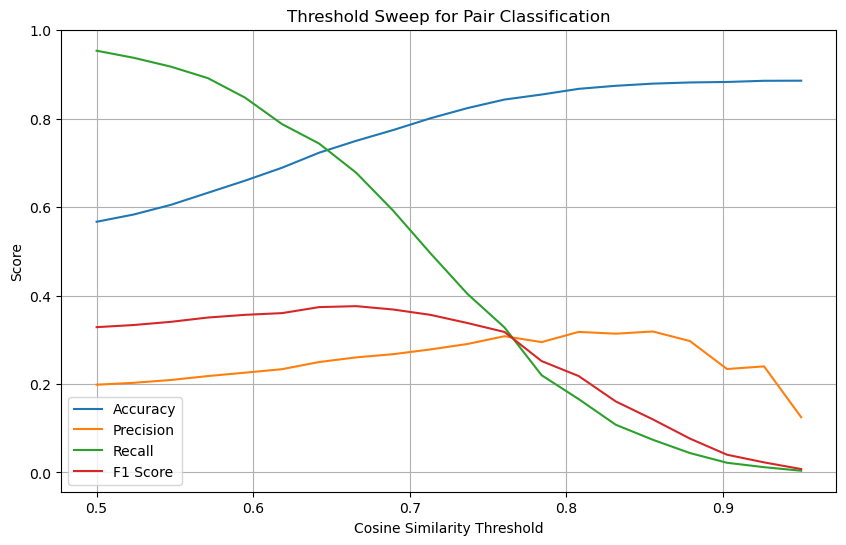

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# ----- Part 1: Sweep thresholds -----
thresholds = np.linspace(0.5, 0.95, 20)
metrics = {"threshold": [], "accuracy": [], "precision": [], "recall": [], "f1": []}

for t in thresholds:
    pred = (np.sum(emb_left * emb_right, axis=1) >= t).astype(int)
    y_true = df_pairs["label"].astype(int)
    
    metrics["threshold"].append(t)
    metrics["accuracy"].append(accuracy_score(y_true, pred))
    metrics["precision"].append(precision_score(y_true, pred, zero_division=0))
    metrics["recall"].append(recall_score(y_true, pred, zero_division=0))
    metrics["f1"].append(f1_score(y_true, pred, zero_division=0))

# Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(metrics["threshold"], metrics["accuracy"], label="Accuracy")
plt.plot(metrics["threshold"], metrics["precision"], label="Precision")
plt.plot(metrics["threshold"], metrics["recall"], label="Recall")
plt.plot(metrics["threshold"], metrics["f1"], label="F1 Score")
plt.xlabel("Cosine Similarity Threshold")
plt.ylabel("Score")
plt.title("Threshold Sweep for Pair Classification")
plt.legend()
plt.grid(True)
plt.show()

# Cosine Similarity Distributions for Matches vs. Non-Matches

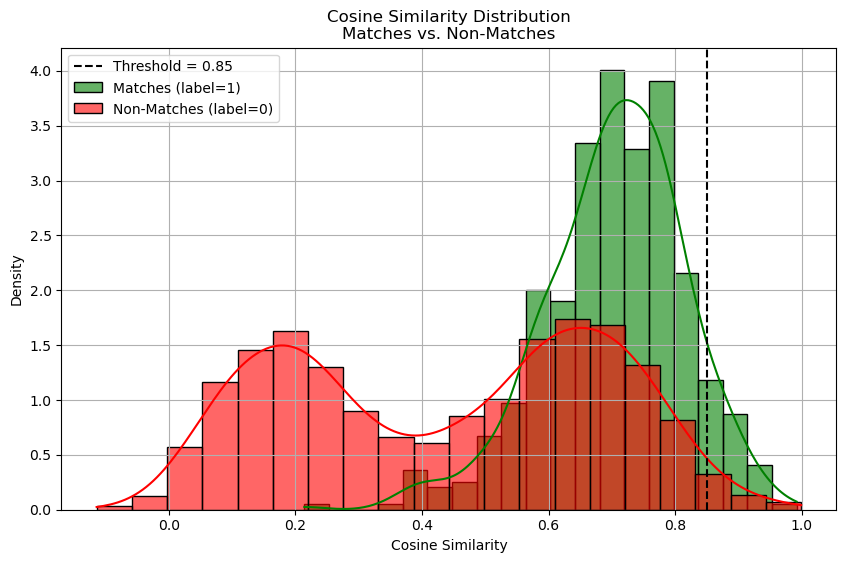

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute cosine similarities (dot product of normalized vectors)
cosine_similarities = np.sum(emb_left * emb_right, axis=1)

# Separate into match / non-match groups based on label
labels = df_pairs["label"].astype(int)
sims_match = cosine_similarities[labels == 1]
sims_nonmatch = cosine_similarities[labels == 0]

# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(sims_match, bins=20, kde=True, color='green', label="Matches (label=1)", stat="density", alpha=0.6)
sns.histplot(sims_nonmatch, bins=20, kde=True, color='red', label="Non-Matches (label=0)", stat="density", alpha=0.6)

plt.axvline(0.85, color='black', linestyle='--', label="Threshold = 0.85")
plt.title("Cosine Similarity Distribution\nMatches vs. Non-Matches")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


Many non-matches (red) have high similarity — some even above 0.8.

Some true matches (green) fall below 0.7 — which is low for semantic similarity.

# Input structuring and Better model

In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import faiss

# Step 1: Structured formatting function
def format_structured(row, side):
    return f"TITLE: {row.get(f'title_{side}', '')}. " \
           f"BRAND: {row.get(f'brand_{side}', '')}. " \
           f"DESC: {row.get(f'description_{side}', '')}. " \
           f"PRICE: {row.get(f'price_{side}', '')} {row.get(f'priceCurrency_{side}', '')}."

df_pairs["text_left"] = df_pairs.apply(lambda row: format_structured(row, "left"), axis=1)
df_pairs["text_right"] = df_pairs.apply(lambda row: format_structured(row, "right"), axis=1)

# Step 2: Use a stronger embedding model
model = SentenceTransformer("all-mpnet-base-v2")

# Step 3: Embed and normalize
print("Encoding records...")
emb_left = model.encode(df_pairs["text_left"].tolist(), normalize_embeddings=True, show_progress_bar=True)
emb_right = model.encode(df_pairs["text_right"].tolist(), normalize_embeddings=True, show_progress_bar=True)

# Step 4: Build FAISS index on right embeddings
dim = emb_right.shape[1]
index = faiss.IndexHNSWFlat(dim, 32)
index.hnsw.efConstruction = 40
index.hnsw.efSearch = 50
index.add(emb_right)

# Step 5: Compute cosine similarity (dot product of normalized vectors)
cosine_similarities = np.sum(emb_left * emb_right, axis=1)

# Step 6: Threshold-based classification
threshold = 0.85
pred_labels = (cosine_similarities >= threshold).astype(int)
true_labels = df_pairs["label"].astype(int)

acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
rec = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print("\n📊 Evaluation Metrics")
print(f"Threshold: {threshold}")
print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1 Score:  {f1:.2f}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\User\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding records...


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Batches:   0%|          | 0/141 [00:00<?, ?it/s]


📊 Evaluation Metrics
Threshold: 0.85
Accuracy:  0.87
Precision: 0.36
Recall:    0.23
F1 Score:  0.28


## Compare the two models

In [23]:
from sentence_transformers import SentenceTransformer

# Load MiniLM model (lightweight baseline)
model_minilm = SentenceTransformer("all-MiniLM-L6-v2")

# Re-embed using MiniLM
print("Encoding with MiniLM...")
emb_left_minilm = model_minilm.encode(df_pairs["text_left"].tolist(), normalize_embeddings=True, show_progress_bar=True)
emb_right_minilm = model_minilm.encode(df_pairs["text_right"].tolist(), normalize_embeddings=True, show_progress_bar=True)


Encoding with MiniLM...


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

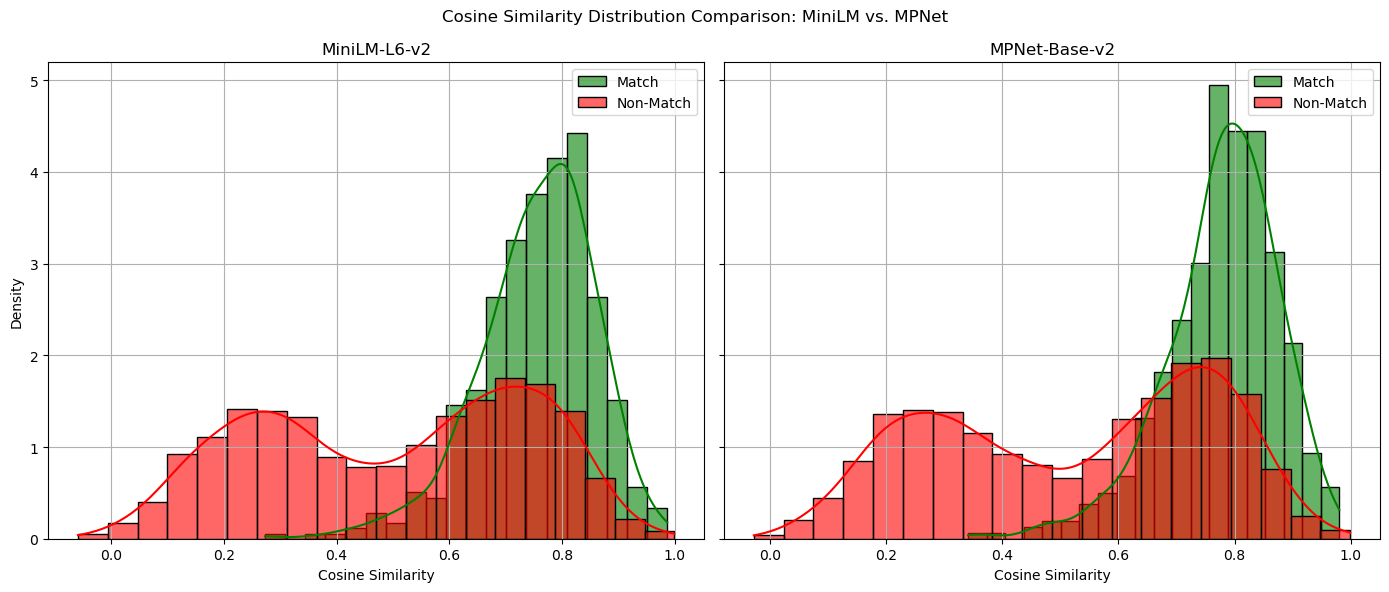

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute cosine similarities
cosine_minilm = np.sum(emb_left_minilm * emb_right_minilm, axis=1)
cosine_mpnet = np.sum(emb_left * emb_right, axis=1)  # emb_left/right = mpnet

labels = df_pairs["label"].astype(int)
sims_minilm_match = cosine_minilm[labels == 1]
sims_minilm_nonmatch = cosine_minilm[labels == 0]
sims_mpnet_match = cosine_mpnet[labels == 1]
sims_mpnet_nonmatch = cosine_mpnet[labels == 0]

# Plot both
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.histplot(sims_minilm_match, bins=20, kde=True, color='green', label="Match", stat="density", ax=axs[0], alpha=0.6)
sns.histplot(sims_minilm_nonmatch, bins=20, kde=True, color='red', label="Non-Match", stat="density", ax=axs[0], alpha=0.6)
axs[0].set_title("MiniLM-L6-v2")
axs[0].set_xlabel("Cosine Similarity")
axs[0].legend()
axs[0].grid(True)

sns.histplot(sims_mpnet_match, bins=20, kde=True, color='green', label="Match", stat="density", ax=axs[1], alpha=0.6)
sns.histplot(sims_mpnet_nonmatch, bins=20, kde=True, color='red', label="Non-Match", stat="density", ax=axs[1], alpha=0.6)
axs[1].set_title("MPNet-Base-v2")
axs[1].set_xlabel("Cosine Similarity")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Cosine Similarity Distribution Comparison: MiniLM vs. MPNet")
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import roc_auc_score

# Cosine similarity as scores
cosine_minilm = np.sum(emb_left_minilm * emb_right_minilm, axis=1)
cosine_mpnet  = np.sum(emb_left * emb_right, axis=1)

true_labels = df_pairs["label"].astype(int)

# Compute AUC
auc_minilm = roc_auc_score(true_labels, cosine_minilm)
auc_mpnet  = roc_auc_score(true_labels, cosine_mpnet)

print(f"📊 AUC Comparison:")
print(f"MiniLM-L6-v2     AUC: {auc_minilm:.3f}")
print(f"MPNet-Base-v2    AUC: {auc_mpnet:.3f}")


📊 AUC Comparison:
MiniLM-L6-v2     AUC: 0.814
MPNet-Base-v2    AUC: 0.821


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def evaluate_over_thresholds(similarities, labels, name):
    thresholds = np.linspace(0.5, 0.95, 100)
    best_f1 = 0
    best_threshold = 0
    best_metrics = {}

    for t in thresholds:
        preds = (similarities >= t).astype(int)
        prec = precision_score(labels, preds, zero_division=0)
        rec = recall_score(labels, preds, zero_division=0)
        f1 = f1_score(labels, preds, zero_division=0)
        acc = accuracy_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_metrics = {
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1
            }

    print(f"\n📊 Best Threshold Evaluation for {name}")
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Accuracy:       {best_metrics['accuracy']:.3f}")
    print(f"Precision:      {best_metrics['precision']:.3f}")
    print(f"Recall:         {best_metrics['recall']:.3f}")
    print(f"F1 Score:       {best_metrics['f1']:.3f}")
    return best_threshold, best_metrics

# Run for both models
true_labels = df_pairs["label"].astype(int)

cosine_minilm = np.sum(emb_left_minilm * emb_right_minilm, axis=1)
cosine_mpnet  = np.sum(emb_left * emb_right, axis=1)

best_thresh_minilm, metrics_minilm = evaluate_over_thresholds(cosine_minilm, true_labels, "MiniLM-L6-v2")
best_thresh_mpnet, metrics_mpnet  = evaluate_over_thresholds(cosine_mpnet, true_labels, "MPNet-Base-v2")



📊 Best Threshold Evaluation for MiniLM-L6-v2
Best Threshold: 0.72
Accuracy:       0.752
Precision:      0.265
Recall:         0.694
F1 Score:       0.383

📊 Best Threshold Evaluation for MPNet-Base-v2
Best Threshold: 0.75
Accuracy:       0.769
Precision:      0.280
Recall:         0.690
F1 Score:       0.399
